# Projet de Télédétection : Cartographie des strates végétales (Pyrénées 24-25)
## 1. Initialisation de l'environnement

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from osgeo import gdal

# Imports Scikit-Learn (Vus au TD Classification)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Ajout du chemin vers tes scripts personnels et ceux du prof
# Assure-toi que le dossier contenant libsigma est bien ici
sys.path.append('/home/onyxia/work/') 

from libsigma import read_and_write as rw
from libsigma import classification as cla
# Tu devras créer ce fichier pour tes fonctions perso comme demandé dans le projet
#import my_function as mf 

# Configuration des dossiers
data_dir = "data/"
results_dir = "results/"
fig_dir = os.path.join(results_dir, "figure/")

# Création des dossiers de sortie si inexistants (Bonne pratique TD)
os.makedirs(fig_dir, exist_ok=True)

print("Environnement chargé.")

Environnement chargé.


# 2. Analyse Initiale des Échantillons
## 2.1. Distribution du jeu de données (Polygones et Pixels)

In [2]:
import sys
import os

# Ajoutez le chemin vers le DOSSIER contenant my_function.py
sys.path.append('/home/onyxia/work/projet_teledec/notebook/') 

# Maintenant Python va trouver le fichier dans ce dossier
import my_function as mf 


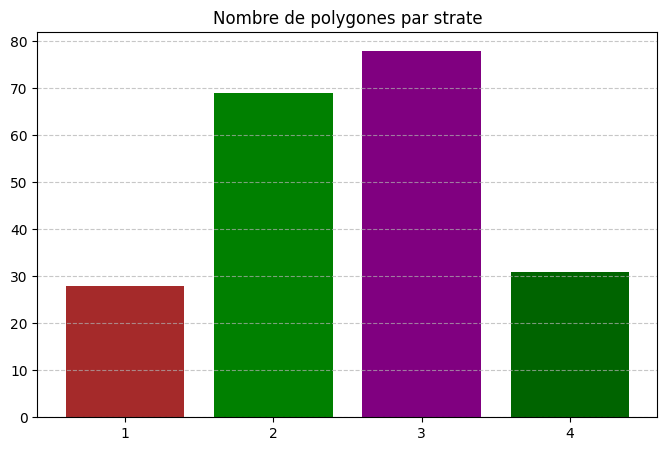

/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Rasterisation terminée : /home/onyxia/work/data/projet_eval/sample_strata.tif


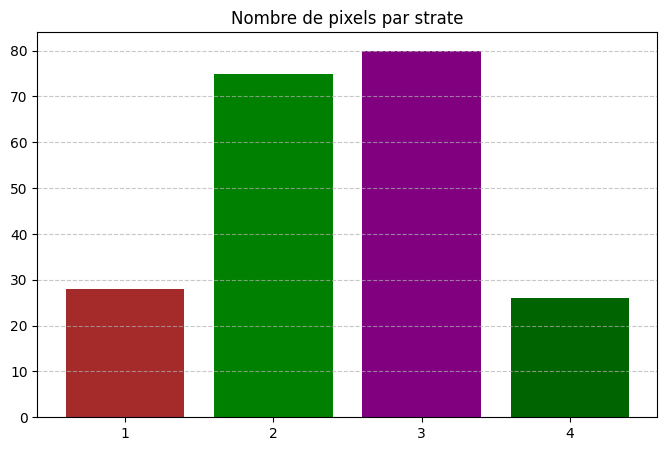

In [ ]:
import sys
import os
import my_function as mf 

sys.path.append('/home/onyxia/work/projet_teledec/notebook/') 


# --- Analyse des Polygones ---
# Assurez-vous que les chemins vers vos données (.shp) sont aussi corrects
mf.plot_poly_counts(
    shp_path='/home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp',
    col_classe='strate',
    output_path='results/figure/diag_baton_nb_poly_by_class.png'
)
# --- Rasterisation ---
mf.rasterize_shapefile(
    image_ref_path='/home/onyxia/work/data/projet_eval/pyrenees_24-25_B02.tif',
    shp_path='/home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp',
    output_raster='/home/onyxia/work/data/projet_eval/sample_strata.tif'
)

# --- Analyse des Pixels ---
mf.plot_pixel_counts(
    raster_path='/home/onyxia/work/data/projet_eval/sample_strata.tif',
    output_path='results/figure/diag_baton_nb_pix_by_class.png'
)

## 1. Analyse de l'échantillonnage 
    
Cette étape sert à évaluer la qualité de la base d'apprentissage avant de lancer l'algorithme de classification. Nous analysons ici la représentativité des quatre classes : 1 (Sol Nu), 2 (Herbe), 3 (Landes) et 4 (Arbres).

### 1.1. Distribution par polygones
L'analyse du nombre de polygones par strate montre un déséquilibre dans la collecte des données de terrain :
Dominante : La classe 3 (Landes) est la mieux représentée avec près de 80 polygones.
Minoritaire : Les classes 1 (Sol Nu) et 4 (Arbres) disposent de moins de 35 polygones chacune.
Intermédiaire : La classe 2 (Herbe) présente un échantillonnage solide avec environ 70 polygones.

### 1.2. Distribution par pixels
Après rasterisation, la distribution des pixels confirme la tendance observée au niveau des polygones :
Les Landes (3) et l'Herbe (2) ont le plus grand volume de pixels (entre 75 et 80 pixels par classe).
Le Sol Nu (1) et les Arbres (4) restent sous-représentés avec moins de 30 pixels chacun.

### 1.3. Synthèse et impact sur le modèle
Le déséquilibre observé est un point de vigilance pour la suite du projet :
Risque de biais : L'algorithme Random Forest pourrait avoir une tendance naturelle à surestimer les classes majoritaires (Landes/Herbe) au détriment des classes minoritaires (Arbres/Sol Nu).
Indépendance : Pour limiter ce biais, j'ai choisi d'utiliser StratifiedGroupKFold lors de l'optimisation. Elle permettra de s'assurer que les pixels d'un même polygone entre l'entraînement et le test ne se mélangent pas.

# 3. Caractérisation des Landes (Analyse Phénologique)
## 3.1. Calcul de l'indice NARI (Normalized Anthocyanin Reflectance Index)

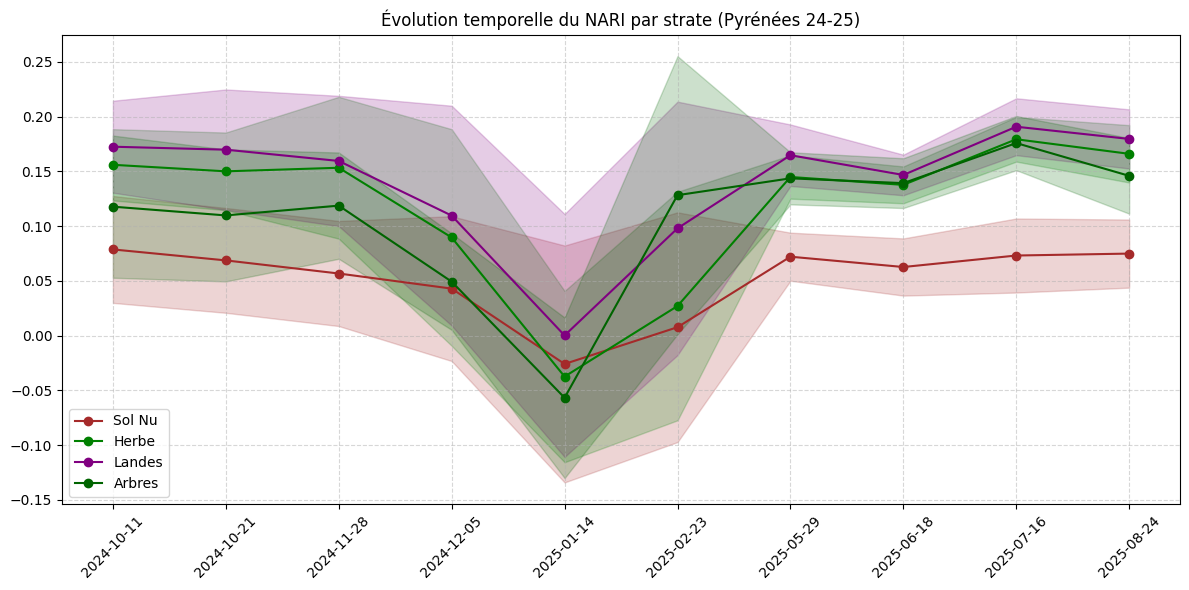

In [4]:
import my_function as mf

# Paramètres
dates_list = ['2024-10-11', '2024-10-21', '2024-11-28', '2024-12-05', '2025-01-14',
              '2025-02-23', '2025-05-29', '2025-06-18', '2025-07-16', '2025-08-24']
data_folder = '/home/onyxia/work/data/projet_eval'
fig_save_path = '/home/onyxia/work/projet_teledec/notebook/results/figure/ARI_series.png'

# Appel de la fonction
mf.process_nari_phenology(data_folder, dates_list, fig_save_path)



## 2. Analyse de l'évolution temporelle 
La série temporelle (octobre 2024 à aout 2025) montre des dynamiques phénologiques distinctes pour chaque classe : 

En octobre : Les classes sont relativement distinctes, on observe bien les differences entre sol nu et Arbres et Landes/herbes. 
En novembre : Les classes Landes et herbes se chevauchent, ils sont très similaires, il est difficile de les differentier 
En janvier : Les classes deviennent difficiles a distinguer, c'est peut être du à la presence de neigne, et l'abscence de végetation
En été, de mai à aout : Seule la classe sol est considérablement distincte des autres classes, les classes herbes landes et Arbres ont des valeurs de NARI très similaire (végétation dense)

Le NARI, servant à detecter les anthocyanes permet bien d'isoler les Landes du sol nu mais ne permet pas de séparer efficacement les 4 classes. 
    

In [5]:
import my_function as mf

# Paramètres
base_data = '/home/onyxia/work/data/projet_eval'
nari_output = '/home/onyxia/work/projet_teledec/notebook/results/ARI_serie_temp.tif'

# Exécution
mf.create_nari_raster(base_data, nari_output)

Raster NARI créé : /home/onyxia/work/projet_teledec/notebook/results/ARI_serie_temp.tif


# 4. Production de la Carte par Machine Learning
## 4.1. Préparation et Optimisation (Random Forest)

In [6]:
import my_function as mf
from libsigma import classification as cla

# Paramètres
base_dir = '/home/onyxia/work/data/projet_eval'
image_ref = base_dir + '/pyrenees_24-25_B02.tif'
shp_path = base_dir + '/PI_strates_pyrenees_32630.shp'
out_samples = base_dir + '/sample_strata.tif'
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

# Appel de la fonction
X, Y, groups = mf.prepare_classification_data(base_dir, image_ref, shp_path, out_samples, bands)

Données prêtes : X(209, 100), Y(209,), Groupes : 83


## 4.2. Évaluation et Importance des Variables

Lancement de l'optimisation...
Fitting 5 folds for each of 120 candidates, totalling 600 fits


Meilleurs paramètres : {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 150}

RAPPORT DE CLASSIFICATION (Test 30%)
              precision    recall  f1-score   support

      Sol Nu       0.88      0.88      0.88         8
       Herbe       0.79      0.83      0.81        23
      Landes       0.79      0.79      0.79        24
      Arbres       1.00      0.88      0.93         8

    accuracy                           0.83        63
   macro avg       0.86      0.84      0.85        63
weighted avg       0.83      0.83      0.83        63



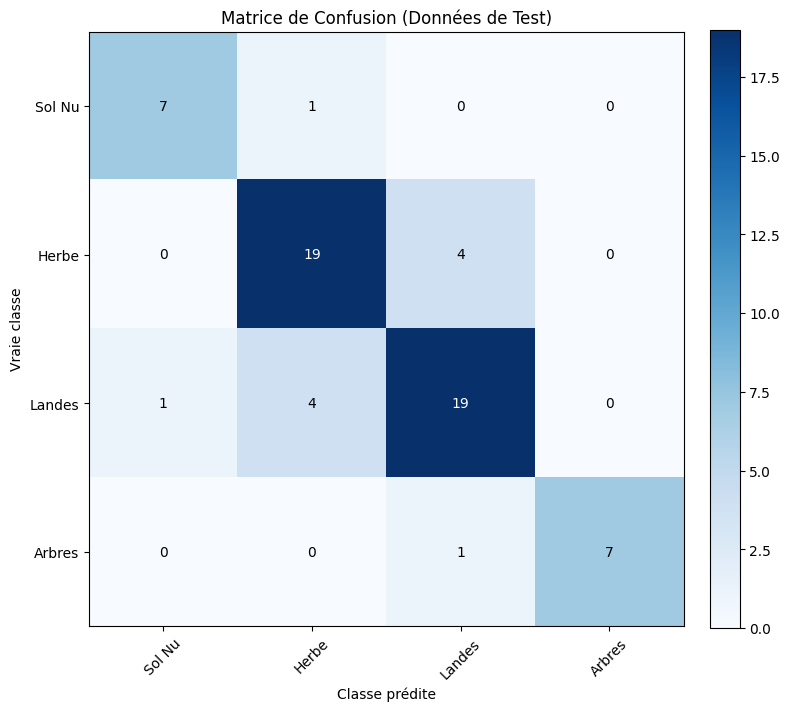

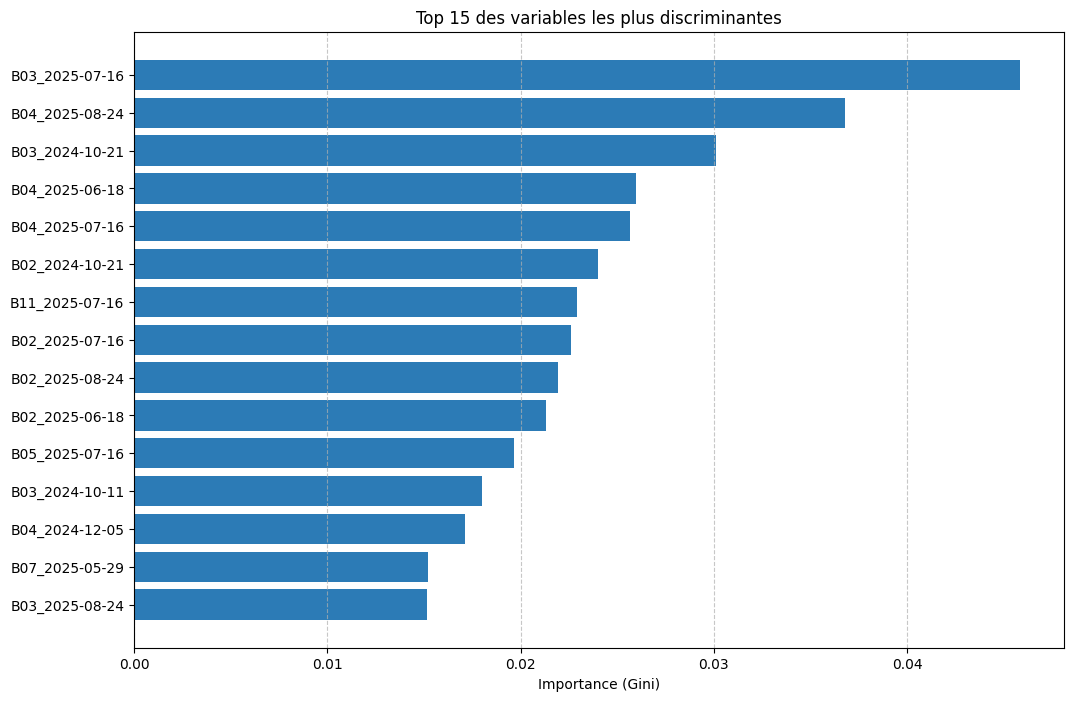

In [7]:
import my_function as mf
import importlib
importlib.reload(mf)

# --- CONFIGURATION DES PARAMÈTRES ---
# On définit ici toutes les variables qui manquaient
target_names = ['Sol Nu', 'Herbe', 'Landes', 'Arbres']
bandes = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
dates_reelles = ['2024-10-11', '2024-10-21', '2024-11-28', '2024-12-05', '2025-01-14',
                 '2025-02-23', '2025-05-29', '2025-06-18', '2025-07-16', '2025-08-24']

# 1. OPTIMISATION
# On récupère le modèle optimisé via GridSearch
best_clf = mf.optimize_random_forest(X, Y, groups)

# 2. ÉVALUATION (Split 70/30 interne)
# On récupère le modèle entraîné sur les 70% pour pouvoir lire les importances après
best_clf = mf.evaluate_model(
    model=best_clf, 
    X=X, 
    Y=Y, 
    target_names=target_names,
    output_fig_path='results/figure/matrice_confusion_test.png'
)

# 3. AFFICHAGE DES VARIABLES CONTRIBUTIVES
# On utilise le modèle renvoyé par evaluate_model
mf.plot_feature_importance_dates(
    model=best_clf, 
    band_names=bandes, 
    dates=dates_reelles, 
    output_path='results/figure/feature_importance_top15.png'
)

## Analyse de la matrice de confusion

Le modèle fonctinne globalement bien avec une précision globale de 83%

Comme attendu, les classes les mieux classés sont les arbres  (100% de précision) et le sol nu (88% de recall)

La confusion majeur reste entre les classes Herbes et Landes : 4 pixels d'herbe ont été pris pour de la lande, et inversement. Cette confusion s'explique par la proximité spectrale de ces 2 classes en été et au printemps notamment.

L'analyse de l'importance des variables confirme que le modèle s'appuie principalement sur les bandes B03 et B04.
La bande B04 (Rouge) permets de distinguer la végétation du sol. Elle renseigne sur la chlorophylle, la végétation a donc des valeurs d'absorption basses et le sol, qui n'absorbent pas la lumière rouge aura au contraire des valeurs plus élevées.

La bande B03 (vert) est un indicateur des pigments. Elle mesure la lumière réfléchie par les feuilles dans le vert et permets la differenciation des classes de végétation.




## Analyse Spectrale Saisonnière

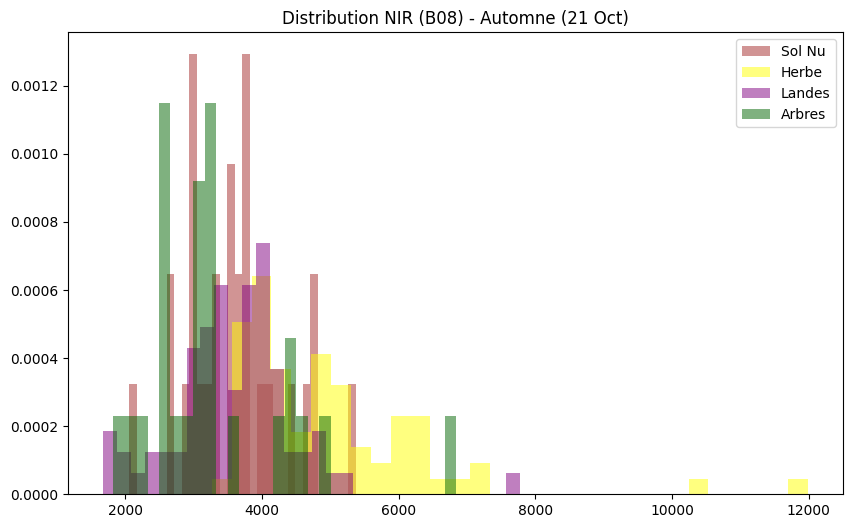

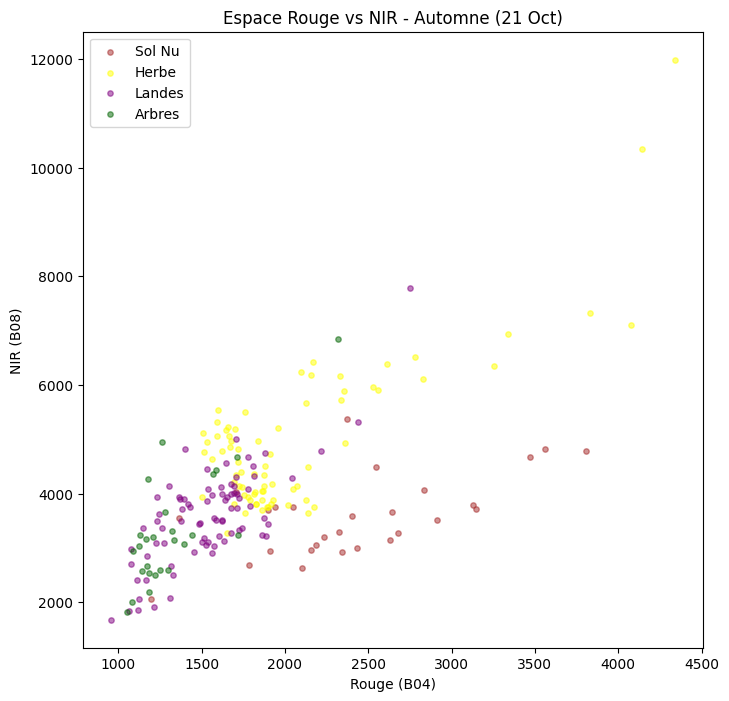

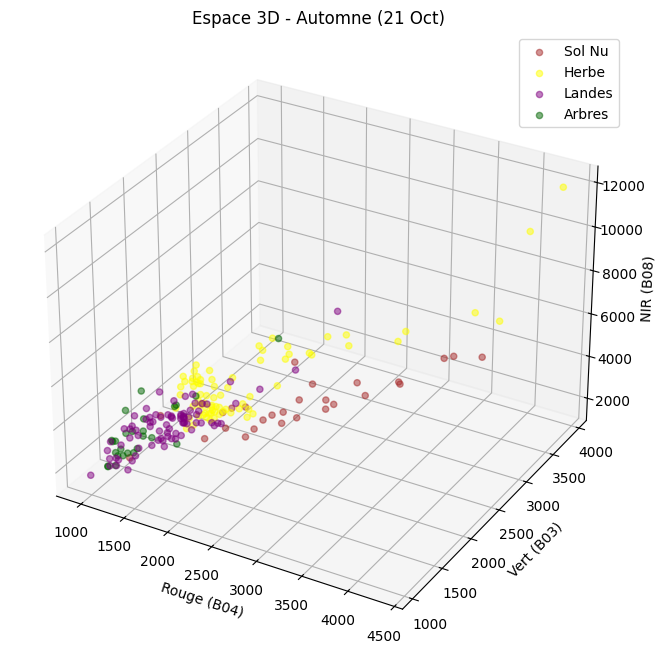

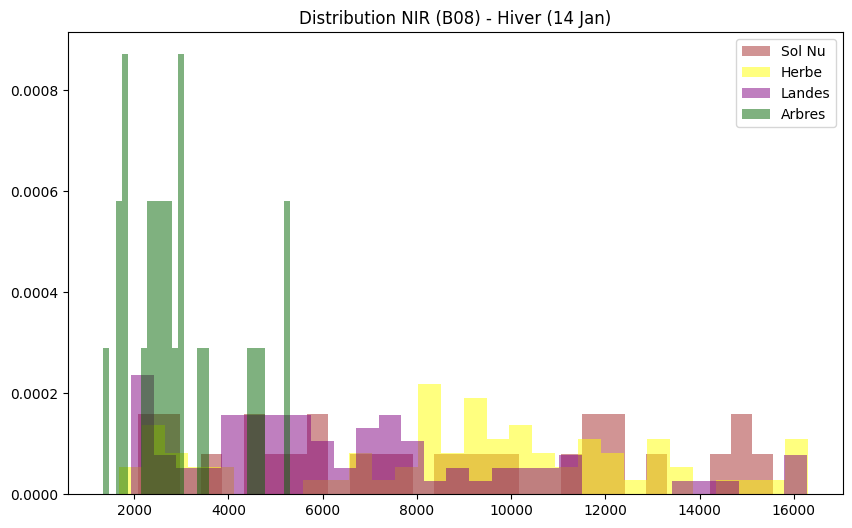

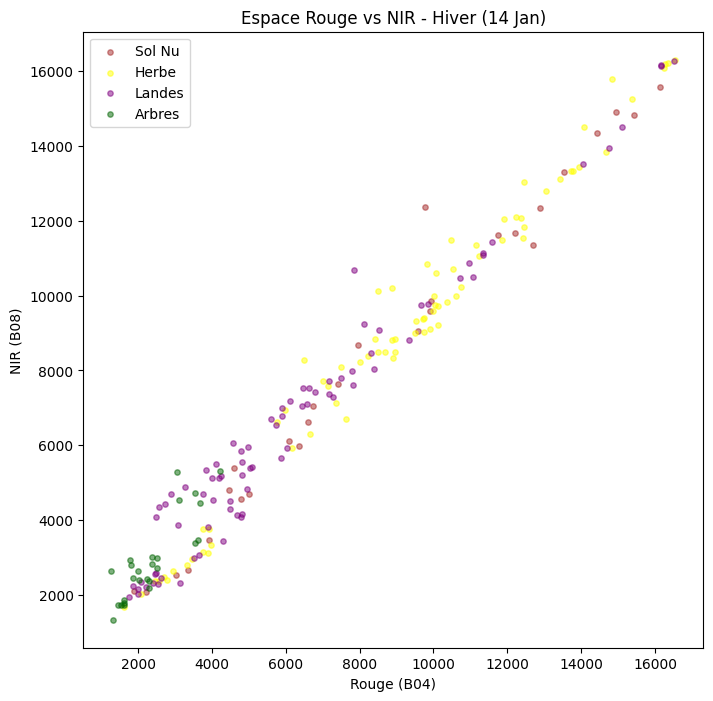

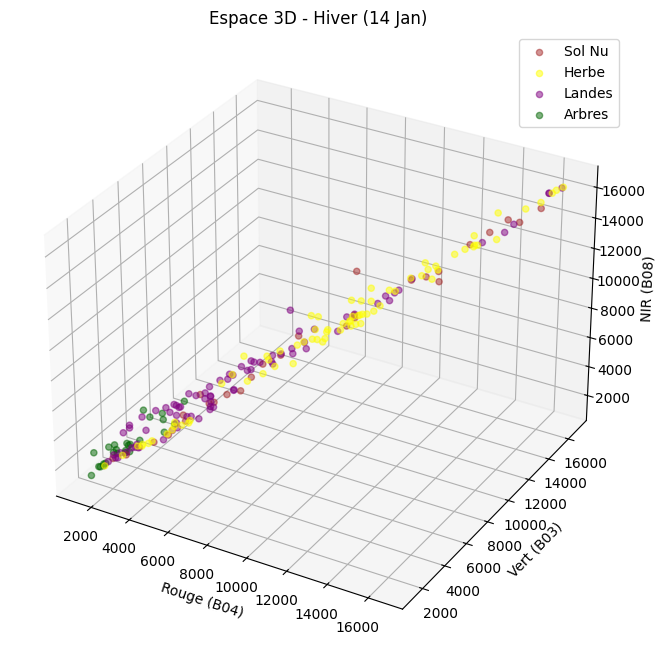

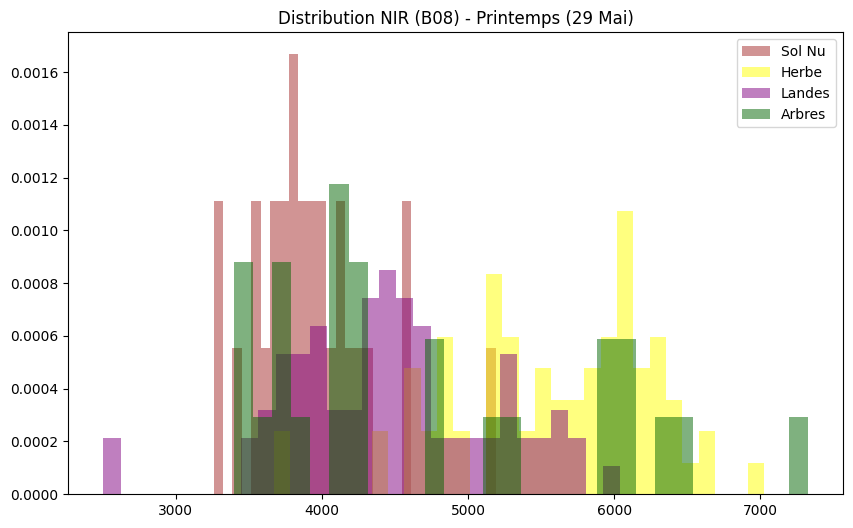

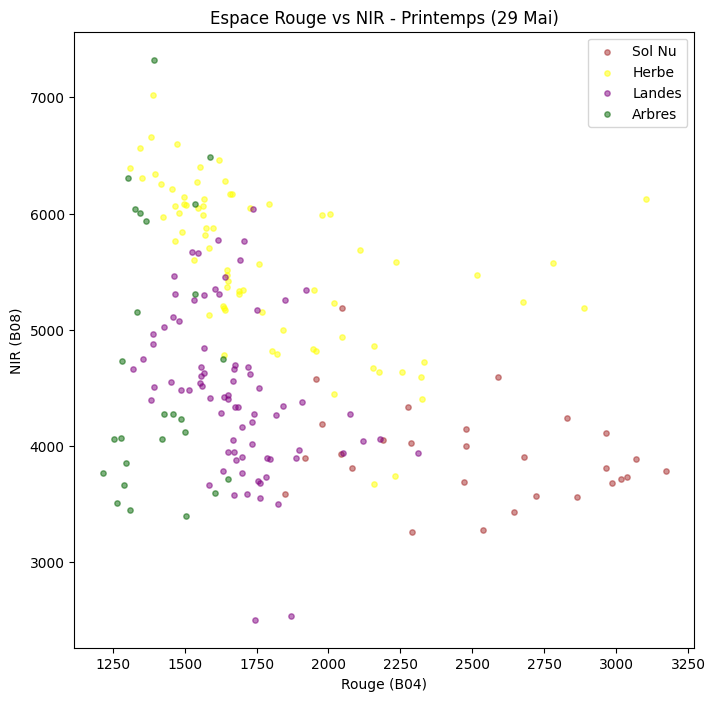

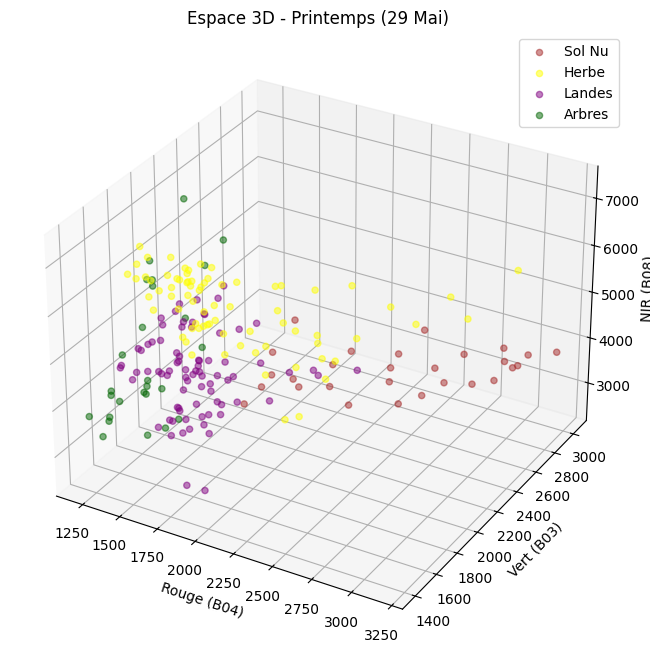

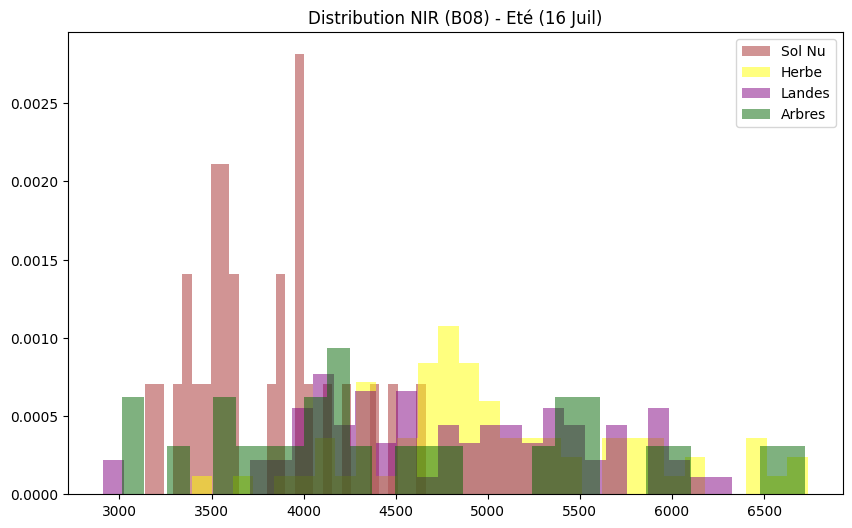

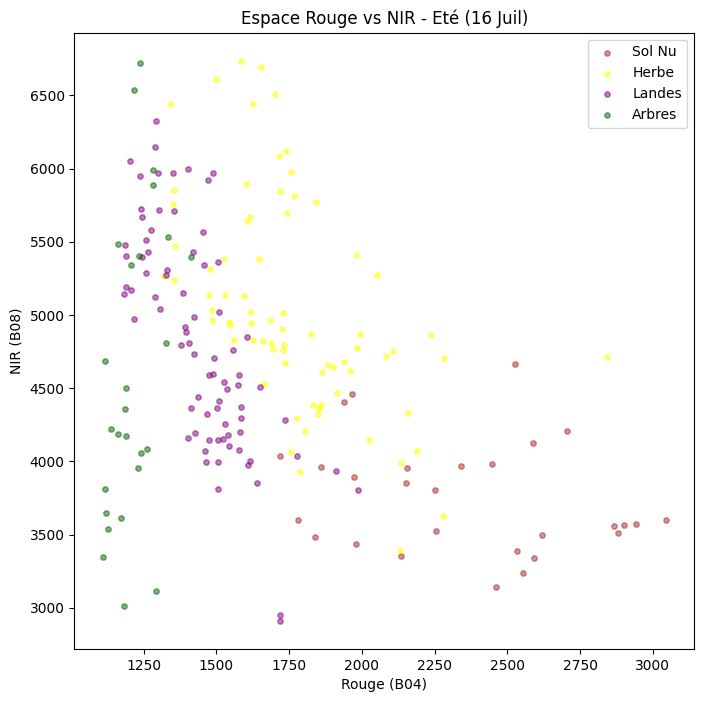

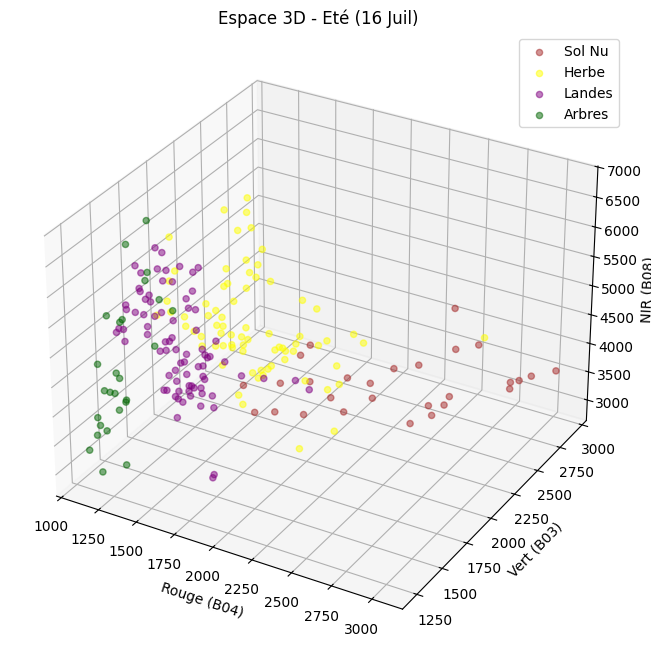

In [8]:
import my_function as mf

# On définit le dossier où enregistrer les images
results_fig_dir = 'results/figure'

# Appel de la fonction globale d'analyse
mf.plot_data_analysis(X, Y, results_fig_dir)

## Analyse de la séparabilité spectrale des strates
### 1. Analyse de la distribution NIR (B08) par saison
La distribution des réflectances dans le proche infrarouge (NIR) varie considérablement selon le cycle phénologique :

Hiver : Le signal est dominé par un albédo très élevé (jusqu'à 16 000) et une forte dispersion. La présence du manteau neigeux rend les classes indissociables sur cette bande.

Été : Les signatures sont plus resserrées avec un maximum autour de 7 000. On observe un fort recouvrement entre les Landes et les Arbres, alors que l'Herbe commence à se détacher vers les hautes valeurs de réflectance.

Automne : Les contrastes s'estompent avec le déclin de l'activité photosynthétique. Les Landes (violet) sont spectralement fondues dans la signature des Arbres, confirmant que le NIR seul ne permet pas leur distinction à cette date.

### 2. Espace spectral : Rouge (B04) vs NIR (B08)
Les diagrammes de dispersion 2D illustrent la structure de la végétation et sa séparabilité selon le profil spectral classique :

Printemps : Il s'agit de la période optimale pour la distinction. L'Herbe s'isole nettement en haut à gauche (faible Rouge, fort NIR), tandis que le Sol Nu s'étire vers la droite du graphique (fort Rouge, NIR moyen).

Été : La dispersion est maximale pour le Sol Nu, signe d'une forte hétérogénéité des surfaces minérales. Les classes végétales restent toutefois groupées, compliquant leur distinction précise.

Hiver : Les points s'alignent sur une droite de corrélation parfaite. Cela traduit un signal binaire (neige vs hors-neige) sans distinction biologique utile pour la classification.

### 3. Analyse de l'espace 3D (Rouge, Vert, NIR)
L'ajout de la bande du Vert (B03) permet d'explorer la structure volumétrique des données spectrales et d'améliorer la discrimination :

Hiver & Automne : Le nuage de points est très aplati ou linéaire. Cela indique une forte redondance d'information entre les bandes spectrales à ces périodes.

Printemps (Mai) : L'espace 3D "déplie" les signatures. Les classes forment des amas plus distincts : l'Herbe occupe le sommet du nuage, tandis que les Landes et les Arbres se séparent légèrement grâce à l'axe du Vert, bien que le recouvrement reste partiel.

Utilité : Cette visualisation 3D justifie l'utilisation d'un algorithme robuste comme le Random Forest. Ce dernier est capable de trouver des frontières de décision complexes dans ce volume là où une analyse sur une simple bande échouerait.

# 4.3. Cartographie Finale

In [9]:
import my_function as mf

# Paramètres
base_dir = '/home/onyxia/work/data/projet_eval'
bandes = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
# Dans ton Notebook
out_path = 'results/carte_strates.tif'
# Production de la carte avec le meilleur modèle trouvé par GridSearch
mf.produce_final_map(best_clf, base_dir, bandes, out_path)

--- Production de la Carte Finale ---
Prédiction sur 3011065 pixels...


Carte terminée et sauvegardée : results/carte_strates.tif



# Conclusion de la Classification et Retour d'Expérience
## 1. Bilan de la cartographie finale
La classification par Random Forest a produit des résultats globalement très satisfaisants pour la zone d'étude des Pyrénées. La carte finale montre une répartition spatiale cohérente des quatre strates végétales :

Fiabilité des extrêmes : Les zones de Sol Nu et de Forêt/Arbres sont très bien identifiées, avec une précision atteignant 100 % pour les arbres.

Persistance des confusions : Comme identifié lors de l'analyse spectrale et confirmé par la matrice de confusion, un "bruit" subsiste entre les classes Herbe et Landes. Ces deux végétations basses partagent des signatures proches en période estivale, ce qui mène à des erreurs lors des tests.

## 2. Optimisation et méthodologie
Le modèle a été stabilisé grâce à une optimisation des paramètres, utilisant 150 arbres de décision et une sélection de variables en log2. L'analyse des variables les plus discriminantes souligne que les bandes du Vert (B03) et du Rouge (B04) en été ont les plus utilisés lors de la classification.

## 3. Note sur l'utilisation de l'assistance IA
Pour ce projet, je me suis basé sur les td vu en cours mais j'ai aussi utilisé l'Intelligence Artificielle pour :

Le déblocage du code : Aide à la structuration des fonctions et résolution des bugs. 

Synhthèse des codes : J'avais des fonctions compliqués et longues, l'IA m'a permis de les rendre plus "propre"

La visualisation des données : Optimisation des scripts Matplotlib pour générer les graphiques en 2D et 3D, permettant une meilleure interprétation de la séparabilité des classes.

